This tutorial refer from https://github.com/tjwei/GANotebooks

In [1]:
from __future__ import print_function
import os
os.environ['KERAS_BACKEND']='tensorflow'

In [2]:
import keras.backend as K
K.set_image_data_format('channels_first')
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dense
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
conv_init = RandomNormal(0, 0.02)

Using TensorFlow backend.


In [3]:
"""
Args:
  isize: input image size
  nc: image channel
  ndf: num of discriminator filters
"""
def DCGAN_D(isize, nc, ndf):
    # Input layers
    inputs = Input(shape=(nc, isize, isize), name="Inputs")
    
    _ = ZeroPadding2D(name="0_ZeroPadding2D")(inputs)
    
    _ = Conv2D(filters=ndf, kernel_size=4, strides=2, 
               use_bias=False, kernel_initializer=conv_init, 
               name="0_Conv2D")(_)
    
    _ = LeakyReLU(alpha=0.2, name="0_LeakyReLU")(_)
    
    # Pyramid layers
    ksize, ndf2, c = isize//2, ndf, 1
    while ksize > 5:
        in_feat = ndf2
        out_feat = ndf2*2
        _ = ZeroPadding2D(name="{}_ZeroPadding2D".format(c))(_)
        
        _ = Conv2D(filters=out_feat, kernel_size=4, strides=2,
                   use_bias=False, kernel_initializer=conv_init,
                   name="{}_Conv2D".format(c))(_)
        
        _ = BatchNormalization(axis=1, epsilon=1.01e-5, 
                               name="{}_BatchNorm".format(c))(_, training=1)
        _ = LeakyReLU(alpha=0.2, name="{}_LeakyReLU".format(c))(_)
        
        ksize, ndf2, c = ksize//2, ndf2*2, c+1
    
    # Last Layers
    _ = Conv2D(filters=1, kernel_size=ksize, strides=1, 
               use_bias=False, name="{}_Conv2D".format(c))(_)
    
    outputs = Flatten(name="Outputs")(_)
    return Model(inputs=inputs, outputs=outputs)

In [4]:
"""
Args:
  isize: input image size
  nz: dimension of input noises
  nc: input channels
  ngf: num of generative filters
"""
def DCGAN_G(isize, nz, nc, ngf):
    # layers constant
    cngf = ngf//2
    ksize = isize
    while ksize > 5:
        cngf = cngf * 2
        ksize = ksize // 2
        
    # Input layers
    inputs = Input(shape=(nz,), name="Inputs")
    
    _ = Reshape((nz, 1, 1), name="Input_Reshape")(inputs)
    
    _ = Conv2DTranspose(filters=cngf, kernel_size=ksize,
                        use_bias=False, kernel_initializer=conv_init,
                        name="0_deConv2D")(_)
    
    _ = BatchNormalization(axis=1, epsilon=1.01e-5, 
                           name="0_BatchNorm")(_, training=1)
    
    _ = Activation("relu", name="0_Relu")(_)
    
    # Pyramid layers
    ksize2, c = ksize, 1
    while ksize2 < isize//2:
        in_feat = cngf
        out_feat = cngf//2
        
        _ = Conv2DTranspose(filters=out_feat, kernel_size=4, strides=2,
                            use_bias=False, kernel_initializer=conv_init,
                            name="{}_deConv2D".format(c))(_)
        
        _ = Cropping2D(cropping=1, name="{}_Crop2D".format(c))(_)
        
        _ = BatchNormalization(axis=1, epsilon=1.01e-5, 
                               name="{}_BatchNorm".format(c))(_, training=1)
        
        _ = Activation('relu', name="{}_Relu".format(c))(_)
        
        ksize2, cngf, c = ksize2*2, cngf//2, c+1
    
    # Last layers
    _ = Conv2DTranspose(filters=nc, kernel_size=4, strides=2, 
                        use_bias=False, kernel_initializer=conv_init,
                        name="{}_deConv2D".format(c))(_)
    
    _ = Cropping2D(cropping=1, name="{}_Crop2D".format(c))(_)
    
    outputs = Activation("tanh", name="Outputs")(_)
    return Model(inputs=inputs, outputs=outputs)

In [5]:
nc = 3
nz = 100
ngf = 64
ndf = 64
n_extra_layers = 0
Diters = 5

imageSize = 64
batchSize = 64
lrD = 0.0003 
lrG = 0.0003 
clamp_lower, clamp_upper = -0.01, 0.01

In [6]:
netD = DCGAN_D(imageSize, nc, ndf)
netD.summary()
if os.path.exists('netD_weights.h5'):
    netD.load_weights('netD_weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          (None, 3, 64, 64)         0         
_________________________________________________________________
0_ZeroPadding2D (ZeroPadding (None, 3, 66, 66)         0         
_________________________________________________________________
0_Conv2D (Conv2D)            (None, 64, 32, 32)        3072      
_________________________________________________________________
0_LeakyReLU (LeakyReLU)      (None, 64, 32, 32)        0         
_________________________________________________________________
1_ZeroPadding2D (ZeroPadding (None, 64, 34, 34)        0         
_________________________________________________________________
1_Conv2D (Conv2D)            (None, 128, 16, 16)       131072    
_________________________________________________________________
1_BatchNorm (BatchNormalizat (None, 128, 16, 16)       512       
__________

In [7]:
netG = DCGAN_G(imageSize, nz, nc, ngf)
netG.summary()
if os.path.exists('netG_weights.h5'):
    netG.load_weights('netG_weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          (None, 100)               0         
_________________________________________________________________
Input_Reshape (Reshape)      (None, 100, 1, 1)         0         
_________________________________________________________________
0_deConv2D (Conv2DTranspose) (None, 512, 4, 4)         819200    
_________________________________________________________________
0_BatchNorm (BatchNormalizat (None, 512, 4, 4)         2048      
_________________________________________________________________
0_Relu (Activation)          (None, 512, 4, 4)         0         
_________________________________________________________________
1_deConv2D (Conv2DTranspose) (None, 256, 10, 10)       2097152   
_________________________________________________________________
1_Crop2D (Cropping2D)        (None, 256, 8, 8)         0         
__________

In [8]:
from keras.optimizers import RMSprop

抑制 Discriminator 的 weights 在 [-0.01, 0.01]

In [9]:
clamp_updates = [K.update(v, K.clip(v, clamp_lower, clamp_upper))
                          for v in netD.trainable_weights]
netD_clamp = K.function([], [], clamp_updates)

訓練 Discriminator 時使用，計算 Wasserstein distance，設定 RMSprop 為訓練函數

In [10]:
netD_real_input = Input(shape=(nc, imageSize, imageSize))
noisev = Input(shape=(nz,))

loss_real = K.mean(netD(netD_real_input))
loss_fake = K.mean(netD(netG(noisev)))
loss = loss_fake - loss_real
training_updates = RMSprop(lr=lrD).get_updates(netD.trainable_weights, [], loss)
netD_train = K.function([netD_real_input, noisev], [loss_real, loss_fake],    
                        training_updates)

訓練 Generator 時使用

In [11]:
loss = -loss_fake
training_updates = RMSprop(lr=lrG).get_updates(netG.trainable_weights, [], loss)
netG_train = K.function([noisev], [loss], training_updates)

載入圖片

In [12]:
import glob
from keras.preprocessing.image import load_img
from scipy.misc import imresize
import numpy as np
import random

"""
load training data
"""
def list_image_pathes(trainDir, testDir):
    print("Loading: {}, {}".format(trainDir, testDir))
    return glob.glob(trainDir+"/*.jpg"), glob.glob(testDir+"/*.jpg")

def random_images(pathes, target_size, batch_size=32):
    rRange = random.randint(0, len(pathes)-batch_size-1)
    randomPathes = pathes[rRange:rRange+batch_size]
    images = [imresize(img, (target_size, target_size)) for img 
                in [load_img(path) for path in randomPathes]]
    images = np.array(images).swapaxes(2,3).swapaxes(1,2).astype(np.float32)
    
    return (images/255)*2-1

trainDir = os.path.join('data', 'cars_train')
testDir = os.path.join('data', 'cars_test')
trainPathes, testPathes = list_image_pathes(trainDir, testDir)
pathes = trainPathes + testPathes

Loading: data/cars_train, data/cars_test


顯示結果

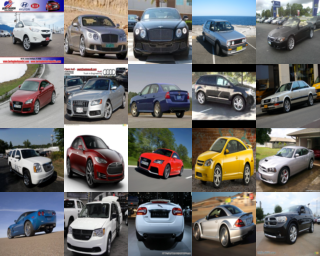

In [13]:
from IPython.display import display
from PIL import Image

def show(X, rows=4):
    assert X.shape[0]%rows == 0
    img_size = X.shape[2]
    int_X = (((X+1)/2)*255).clip(0, 255).astype('uint8')
    int_X = np.moveaxis(int_X.reshape(-1, 3, img_size, img_size), 1, 3)
    int_X = int_X.reshape(rows, -1, img_size, img_size, 3) \
                 .swapaxes(1, 2).reshape(rows*img_size, -1, 3)
    display(Image.fromarray(int_X))

test_show = random_images(pathes, imageSize, 20)
show(test_show)

看成果用的亂數

In [ ]:
fixed_noise = np.random.normal(size=(20, nz)).astype('float32')

訓練囉

epoch: 0/30, times: 0/252, Loss_D: 0.815780878067, Loss_G: [0.64099991], times: 81.8867759705


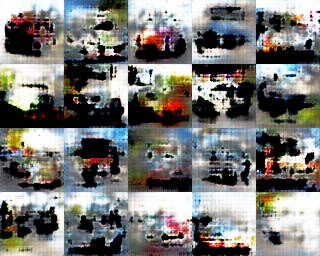

epoch: 0/30, times: 5/252, Loss_D: 1.24959802628, Loss_G: [0.64593923], times: 404.28628397
epoch: 0/30, times: 10/252, Loss_D: 1.09773504734, Loss_G: [0.61969334], times: 645.014192104
epoch: 0/30, times: 15/252, Loss_D: 0.955137193203, Loss_G: [0.49489251], times: 836.031049967
epoch: 0/30, times: 20/252, Loss_D: 0.381347090006, Loss_G: [0.59319168], times: 1004.31332016
epoch: 0/30, times: 25/252, Loss_D: 1.18439733982, Loss_G: [0.61682594], times: 1158.127388
epoch: 0/30, times: 30/252, Loss_D: 1.18089127541, Loss_G: [0.59531939], times: 1303.57038116
epoch: 0/30, times: 35/252, Loss_D: 0.936262786388, Loss_G: [0.44736892], times: 1443.25381517
epoch: 0/30, times: 40/252, Loss_D: 1.13303935528, Loss_G: [0.52887964], times: 1581.65123606
epoch: 0/30, times: 45/252, Loss_D: 0.95776194334, Loss_G: [0.63806105], times: 1718.52450514
epoch: 0/30, times: 50/252, Loss_D: 0.847304344177, Loss_G: [0.22291514], times: 1856.03108406


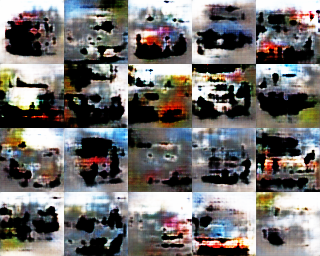

epoch: 0/30, times: 55/252, Loss_D: 1.09987330437, Loss_G: [0.60385382], times: 1994.15492415
epoch: 0/30, times: 60/252, Loss_D: 0.453962117434, Loss_G: [0.58438653], times: 2127.81367302
epoch: 0/30, times: 65/252, Loss_D: 1.07749652863, Loss_G: [0.50961828], times: 2260.16654515
epoch: 0/30, times: 70/252, Loss_D: 0.82110619545, Loss_G: [0.62563312], times: 2391.76602602
epoch: 0/30, times: 75/252, Loss_D: 0.69313544035, Loss_G: [0.62773132], times: 2524.82559705
epoch: 0/30, times: 80/252, Loss_D: 0.809345841408, Loss_G: [0.6205368], times: 2658.66622114
epoch: 0/30, times: 85/252, Loss_D: 1.18328952789, Loss_G: [0.48501042], times: 2795.21620703
epoch: 0/30, times: 90/252, Loss_D: 0.855484068394, Loss_G: [0.24670124], times: 2933.86031199
epoch: 0/30, times: 95/252, Loss_D: 1.01232731342, Loss_G: [0.65544116], times: 3075.83258414
epoch: 0/30, times: 100/252, Loss_D: 0.651432037354, Loss_G: [-0.17637372], times: 3205.86781406


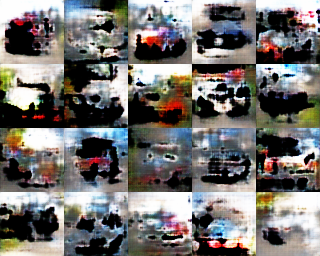

epoch: 0/30, times: 105/252, Loss_D: 0.962301492691, Loss_G: [0.33417398], times: 3344.74965119
epoch: 0/30, times: 110/252, Loss_D: 1.1287560463, Loss_G: [0.55729127], times: 3483.34134197
epoch: 0/30, times: 115/252, Loss_D: 0.99906373024, Loss_G: [0.55785489], times: 3627.56719613
epoch: 0/30, times: 120/252, Loss_D: 1.09470748901, Loss_G: [0.57883394], times: 3765.43664002
epoch: 0/30, times: 125/252, Loss_D: 1.17365539074, Loss_G: [0.51743978], times: 3900.58919096
epoch: 0/30, times: 130/252, Loss_D: 0.981900811195, Loss_G: [0.64294237], times: 4038.85132313
epoch: 0/30, times: 135/252, Loss_D: 0.830285310745, Loss_G: [0.5538708], times: 4174.865659
epoch: 0/30, times: 140/252, Loss_D: 0.932737112045, Loss_G: [0.3829447], times: 4310.5546701
epoch: 0/30, times: 145/252, Loss_D: 0.967027246952, Loss_G: [0.20394443], times: 4443.13243318
epoch: 0/30, times: 150/252, Loss_D: 0.978442490101, Loss_G: [0.63835675], times: 4585.97472


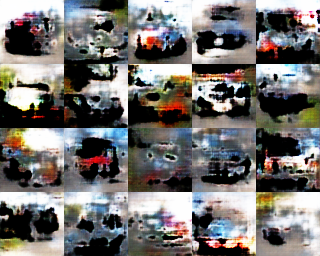

epoch: 0/30, times: 155/252, Loss_D: 0.723627626896, Loss_G: [0.60230917], times: 4723.06179118
epoch: 0/30, times: 160/252, Loss_D: 1.13074374199, Loss_G: [0.47060877], times: 4856.72243619
epoch: 0/30, times: 165/252, Loss_D: 1.12014138699, Loss_G: [0.51496518], times: 5000.71891904
epoch: 0/30, times: 170/252, Loss_D: 0.589386761189, Loss_G: [0.089007668], times: 5141.24609613
epoch: 0/30, times: 175/252, Loss_D: 1.19017136097, Loss_G: [0.62913203], times: 5281.41858816
epoch: 0/30, times: 180/252, Loss_D: 0.822764158249, Loss_G: [0.64560199], times: 5420.59145904
epoch: 0/30, times: 185/252, Loss_D: 0.713988184929, Loss_G: [0.61326653], times: 5564.36009002
epoch: 0/30, times: 190/252, Loss_D: 0.475894749165, Loss_G: [0.60358334], times: 5700.28048897
epoch: 0/30, times: 195/252, Loss_D: 0.704172968864, Loss_G: [0.31573033], times: 5839.52426219
epoch: 0/30, times: 200/252, Loss_D: 0.953711926937, Loss_G: [0.65558219], times: 5979.12471008


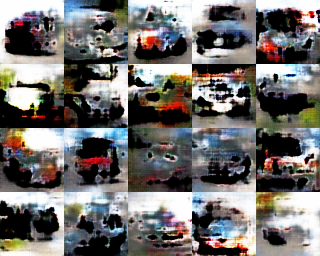

epoch: 0/30, times: 205/252, Loss_D: 1.15078377724, Loss_G: [0.57607913], times: 6116.53192997
epoch: 0/30, times: 210/252, Loss_D: 0.997039914131, Loss_G: [0.39344525], times: 6252.25297117
epoch: 0/30, times: 215/252, Loss_D: 1.08478820324, Loss_G: [0.5742445], times: 6393.50971699
epoch: 0/30, times: 220/252, Loss_D: 0.923330426216, Loss_G: [0.63760388], times: 6530.88329506
epoch: 0/30, times: 225/252, Loss_D: 1.12074422836, Loss_G: [0.53072274], times: 6671.58025098
epoch: 0/30, times: 230/252, Loss_D: 0.777328968048, Loss_G: [0.59819388], times: 6807.63895011
epoch: 0/30, times: 235/252, Loss_D: 0.772754967213, Loss_G: [-0.11000578], times: 6949.24915314
epoch: 0/30, times: 240/252, Loss_D: 1.06518030167, Loss_G: [0.59492153], times: 7089.19024611
epoch: 0/30, times: 245/252, Loss_D: 0.46294978261, Loss_G: [0.54631501], times: 7229.09548807
epoch: 0/30, times: 250/252, Loss_D: 0.858519434929, Loss_G: [0.59734809], times: 7363.20966506


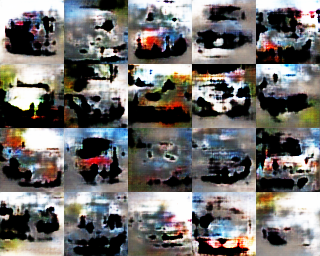

epoch: 1/30, times: 0/252, Loss_D: 0.78326433897, Loss_G: [0.6162858], times: 7414.99240518


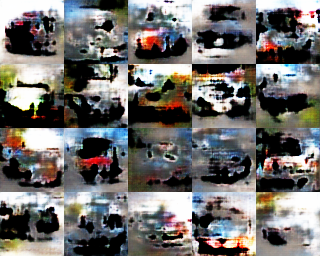

epoch: 1/30, times: 5/252, Loss_D: 1.14368784428, Loss_G: [0.61963737], times: 7552.15894198
epoch: 1/30, times: 10/252, Loss_D: 0.989787459373, Loss_G: [0.59060049], times: 7688.73653007
epoch: 1/30, times: 15/252, Loss_D: 0.90868896246, Loss_G: [0.60284406], times: 7826.67807508
epoch: 1/30, times: 20/252, Loss_D: 1.12309741974, Loss_G: [0.58837897], times: 7964.3276372
epoch: 1/30, times: 25/252, Loss_D: 1.16230940819, Loss_G: [0.64039087], times: 8099.19343209
epoch: 1/30, times: 30/252, Loss_D: 1.03423953056, Loss_G: [0.39795166], times: 8238.13496113
epoch: 1/30, times: 35/252, Loss_D: 0.77981364727, Loss_G: [0.16314055], times: 8372.42491913
epoch: 1/30, times: 40/252, Loss_D: 0.752798318863, Loss_G: [0.64617258], times: 8507.5864141
epoch: 1/30, times: 45/252, Loss_D: 0.981924653053, Loss_G: [0.5957737], times: 8647.6963532
epoch: 1/30, times: 50/252, Loss_D: 0.796695411205, Loss_G: [0.6333952], times: 8788.91084409


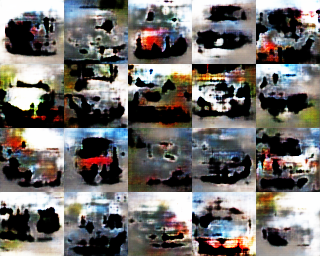

epoch: 1/30, times: 55/252, Loss_D: 0.862146556377, Loss_G: [0.65013742], times: 8922.75296497
epoch: 1/30, times: 60/252, Loss_D: 0.860049843788, Loss_G: [0.64516377], times: 9059.49279714
epoch: 1/30, times: 65/252, Loss_D: 0.564371287823, Loss_G: [0.57286], times: 9197.05111098
epoch: 1/30, times: 70/252, Loss_D: 1.17740809917, Loss_G: [0.55046666], times: 9338.96791601
epoch: 1/30, times: 75/252, Loss_D: 0.572646617889, Loss_G: [0.58414495], times: 9478.04743218
epoch: 1/30, times: 80/252, Loss_D: 0.952183246613, Loss_G: [0.58623362], times: 9610.68468618
epoch: 1/30, times: 85/252, Loss_D: 1.1077286005, Loss_G: [0.59899586], times: 9747.9730022
epoch: 1/30, times: 90/252, Loss_D: 1.07649636269, Loss_G: [0.48185933], times: 9883.46836114
epoch: 1/30, times: 95/252, Loss_D: 1.07837808132, Loss_G: [0.61210632], times: 10021.092958
epoch: 1/30, times: 100/252, Loss_D: 0.52022510767, Loss_G: [0.57806361], times: 10160.6594782


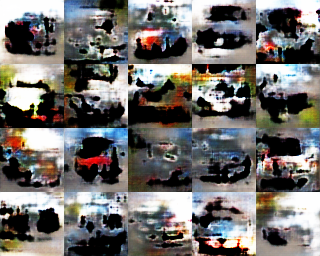

epoch: 1/30, times: 105/252, Loss_D: 0.795789599419, Loss_G: [0.5704627], times: 10298.3254101
epoch: 1/30, times: 110/252, Loss_D: 0.890076637268, Loss_G: [0.59994769], times: 10436.913053
epoch: 1/30, times: 115/252, Loss_D: 0.979731559753, Loss_G: [0.61062789], times: 10577.9820712


In [ ]:
import time
t0 = time.time()
niter = 30
for epoch in range(niter):
    i = 0
    np.random.shuffle(pathes)
    g_exec_times = len(pathes)//batchSize
    for g_times in range(g_exec_times):
        for d_times in range(30):
            netD_clamp([])
            real_data = random_images(pathes, imageSize, batchSize)
            noise = np.random.normal(size=(batchSize, nz))
            errD_real, errD_fake = netD_train([real_data, noise])
            errD = errD_real - errD_fake
        noise = np.random.normal(size=(batchSize, nz))
        errG = netG_train([noise])
        if g_times % 5 == 0:
            print('epoch: {}/{}, times: {}/{}, Loss_D: {}, Loss_G: {}, times: {}'
                  .format(epoch, niter, g_times, g_exec_times, errD, errG, time.time()-t0))
        if g_times % 50 == 0:
            fake = netG.predict(fixed_noise)
            show(fake, 4)

In [ ]:
# netD.save_weights('netD_weights.h5')
# netG.save_weights('netG_weights.h5')